In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, interpolate
from skimage import io, color, feature, img_as_float
from skimage.filters import gaussian, sobel


In [19]:

def load_and_prepare_image(image_path, grayscale=True, smoothing_sigma=1.0):
    """
    Load an image and prepare it for edge detection.

    Parameters:
    -----------
    image_path : str
        Path to the input image.
    grayscale : bool
        Whether to convert image to grayscale.
    smoothing_sigma : float
        Sigma for Gaussian smoothing (noise reduction).

    Returns:
    --------
    numpy.ndarray
        Prepared image
    """
    image = io.imread(image_path)

    if grayscale and len(image.shape) > 2:
        image = color.rgb2gray(image)

    image = img_as_float(image)

    if smoothing_sigma > 0:
        image = gaussian(image, sigma=smoothing_sigma)

    return image


In [20]:

def finite_difference_edge_detection(image, threshold=0.9, method='gradient'):
    """
    Edge detection using finite difference method.

    Parameters:
    -----------
    image : numpy.ndarray
        Input grayscale image.
    threshold : float
        Threshold for edge detection.
    method : str
        'gradient' for gradient magnitude or 'laplacian' for zero-crossing.

    Returns:
    --------
    numpy.ndarray
        Binary edge map.
    """
    rows, cols = image.shape

    if method == 'gradient':

        gradient_x = np.zeros_like(image)
        gradient_x[:, 1:-1] = (image[:, 2:] - image[:, :-2]) / 2.0

        gradient_x[:, 0] = image[:, 1] - image[:, 0]
        gradient_x[:, -1] = image[:, -1] - image[:, -2]


        gradient_y = np.zeros_like(image)
        gradient_y[1:-1, :] = (image[2:, :] - image[:-2, :]) / 2.0

        gradient_y[0, :] = image[1, :] - image[0, :]
        gradient_y[-1, :] = image[-1, :] - image[-2, :]

        gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

        edge_map = gradient_magnitude > threshold

    elif method == 'laplacian':

        laplacian = np.zeros_like(image)
        laplacian[1:-1, 1:-1] = (image[2:, 1:-1] + image[:-2, 1:-1] +
                                 image[1:-1, 2:] + image[1:-1, :-2] -
                                 4 * image[1:-1, 1:-1])

        edge_map = np.zeros_like(image, dtype=bool)

        for i in range(rows-1):
            for j in range(cols-1):
                if (laplacian[i, j] * laplacian[i+1, j] < 0 or
                    laplacian[i, j] * laplacian[i, j+1] < 0 or
                    laplacian[i, j] * laplacian[i+1, j+1] < 0):
                    edge_map[i, j] = True

    return edge_map


In [21]:

def bisection_edge_detection(image, threshold=0.1, tolerance=0.001, max_iterations=20):
    """
    Edge detection using bisection method for root finding.

    Parameters:
    -----------
    image : numpy.ndarray
        Input grayscale image.
    threshold : float
        Reference value for intensity difference.
    tolerance : float
        Convergence tolerance.
    max_iterations : int
        Maximum number of iterations for bisection.

    Returns:
    --------
    numpy.ndarray
        Binary edge map.
    """
    rows, cols = image.shape
    edge_map = np.zeros((rows, cols), dtype=bool)

    def get_interpolated_intensity(i, x):
        if x <= 0:
            return image[i, 0]
        elif x >= cols - 1:
            return image[i, cols - 1]

        x0 = int(np.floor(x))
        x1 = int(np.ceil(x))

        if x0 == x1:
            return image[i, x0]

        t = x - x0
        return (1 - t) * image[i, x0] + t * image[i, x1]

    def get_interpolated_intensity_vertical(y, j):
        if y <= 0:
            return image[0, j]
        elif y >= rows - 1:
            return image[rows - 1, j]

        y0 = int(np.floor(y))
        y1 = int(np.ceil(y))

        if y0 == y1:
            return image[y0, j]

        t = y - y0
        return (1 - t) * image[y0, j] + t * image[y1, j]

    def f(intensity):
        return intensity - threshold

    for i in range(rows):
        for j in range(cols - 1):
            if f(image[i, j]) * f(image[i, j+1]) < 0:
                a, b = float(j), float(j+1)

                for _ in range(max_iterations):
                    if (b - a) < tolerance:
                        break

                    c = (a + b) / 2.0

                    intensity_c = get_interpolated_intensity(i, c)
                    fc = f(intensity_c)

                    intensity_a = get_interpolated_intensity(i, a)
                    fa = f(intensity_a)

                    if fa * fc < 0:
                        b = c
                    else:
                        a = c

                edge_pos = int(round((a + b) / 2))
                if 0 <= edge_pos < cols:
                    edge_map[i, edge_pos] = True

    for j in range(cols):
        for i in range(rows - 1):
            if f(image[i, j]) * f(image[i+1, j]) < 0:
                a, b = float(i), float(i+1)

                for _ in range(max_iterations):
                    if (b - a) < tolerance:
                        break

                    c = (a + b) / 2.0

                    intensity_c = get_interpolated_intensity_vertical(c, j)
                    fc = f(intensity_c)

                    intensity_a = get_interpolated_intensity_vertical(a, j)
                    fa = f(intensity_a)

                    if fa * fc < 0:
                        b = c
                    else:
                        a = c

                edge_pos = int(round((a + b) / 2))
                if 0 <= edge_pos < rows:
                    edge_map[edge_pos, j] = True

    return edge_map


In [25]:

def spline_interpolation_edge_detection(image, threshold=0.9, method='first_derivative'):
    """
    Edge detection using spline interpolation method.

    Parameters:
    -----------
    image : numpy.ndarray
        Input grayscale image.
    threshold : float
        Threshold for edge detection.
    method : str
        'first_derivative' for local maxima or 'second_derivative' for zero-crossings.

    Returns:
    --------
    numpy.ndarray
        Binary edge map.
    """
    rows, cols = image.shape
    edge_map = np.zeros((rows, cols), dtype=bool)

    for i in range(rows):
        x = np.arange(cols)

        y = image[i, :]

        spline = interpolate.CubicSpline(x, y)

        if method == 'first_derivative':
            x_dense = np.linspace(0, cols-1, cols*5)
            first_derivative = spline(x_dense, 1)

            derivative_magnitude = np.abs(first_derivative)

            for j in range(1, len(x_dense)-1):
                if (derivative_magnitude[j] > derivative_magnitude[j-1] and
                    derivative_magnitude[j] > derivative_magnitude[j+1] and
                    derivative_magnitude[j] > threshold):
                    orig_j = int(round(x_dense[j]))
                    if 0 <= orig_j < cols:
                        edge_map[i, orig_j] = True

        elif method == 'second_derivative':
            x_dense = np.linspace(0, cols-1, cols*5)
            second_derivative = spline(x_dense, 2)
            for j in range(len(x_dense)-1):
                if second_derivative[j] * second_derivative[j+1] <= 0:
                    orig_j = int(round(x_dense[j]))
                    if 0 <= orig_j < cols:
                        edge_map[i, orig_j] = True

    for j in range(cols):
        y_coords = np.arange(rows)

        y_values = image[:, j]

        spline = interpolate.CubicSpline(y_coords, y_values)

        if method == 'first_derivative':
            y_dense = np.linspace(0, rows-1, rows*5)
            first_derivative = spline(y_dense, 1)

            derivative_magnitude = np.abs(first_derivative)

            for i in range(1, len(y_dense)-1):
                if (derivative_magnitude[i] > derivative_magnitude[i-1] and
                    derivative_magnitude[i] > derivative_magnitude[i+1] and
                    derivative_magnitude[i] > threshold):
                    orig_i = int(round(y_dense[i]))
                    if 0 <= orig_i < rows:
                        edge_map[orig_i, j] = True

        elif method == 'second_derivative':
            y_dense = np.linspace(0, rows-1, rows*5)
            second_derivative = spline(y_dense, 2)
            for i in range(len(y_dense)-1):
                if second_derivative[i] * second_derivative[i+1] <= 0:
                    orig_i = int(round(y_dense[i]))
                    if 0 <= orig_i < rows:
                        edge_map[orig_i, j] = True

    return edge_map


In [30]:

def compare_edge_detection_methods(image_path):

    image = load_and_prepare_image(image_path, smoothing_sigma=1.0)

    fd_gradient = finite_difference_edge_detection(image, threshold=0.1, method='gradient')
    fd_laplacian = finite_difference_edge_detection(image, threshold=0.1, method='laplacian')
    bisection = bisection_edge_detection(image, threshold=0.5, tolerance=0.001)
    spline_first = spline_interpolation_edge_detection(image, threshold=0.1, method='first_derivative')
    spline_second = spline_interpolation_edge_detection(image, threshold=0.1, method='second_derivative')

    canny_edges = feature.canny(image, sigma=1.0)
    sobel_edges = sobel(image) > 0.1

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original Image')

    axes[0, 1].imshow(fd_gradient, cmap='gray')
    axes[0, 1].set_title('Finite Difference (Gradient)')

    axes[0, 2].imshow(fd_laplacian, cmap='gray')
    axes[0, 2].set_title('Finite Difference (Laplacian)')

    axes[0, 3].imshow(bisection, cmap='gray')
    axes[0, 3].set_title('Sobel')

    axes[1, 0].imshow(spline_first, cmap='gray')
    axes[1, 0].set_title('Spline (First Derivative)')

    axes[1, 1].imshow(spline_second, cmap='gray')
    axes[1, 1].set_title('Spline (Second Derivative)')

    axes[1, 2].imshow(sobel_edges, cmap='gray')
    axes[1, 2].set_title('Bisection Method')


    plt.tight_layout()
    plt.show()

    return {
        "finite_difference_gradient": fd_gradient,
        "finite_difference_laplacian": fd_laplacian,
        "bisection": bisection,
        "spline_first_derivative": spline_first,
        "spline_second_derivative": spline_second,
        "sobel": sobel_edges
    }



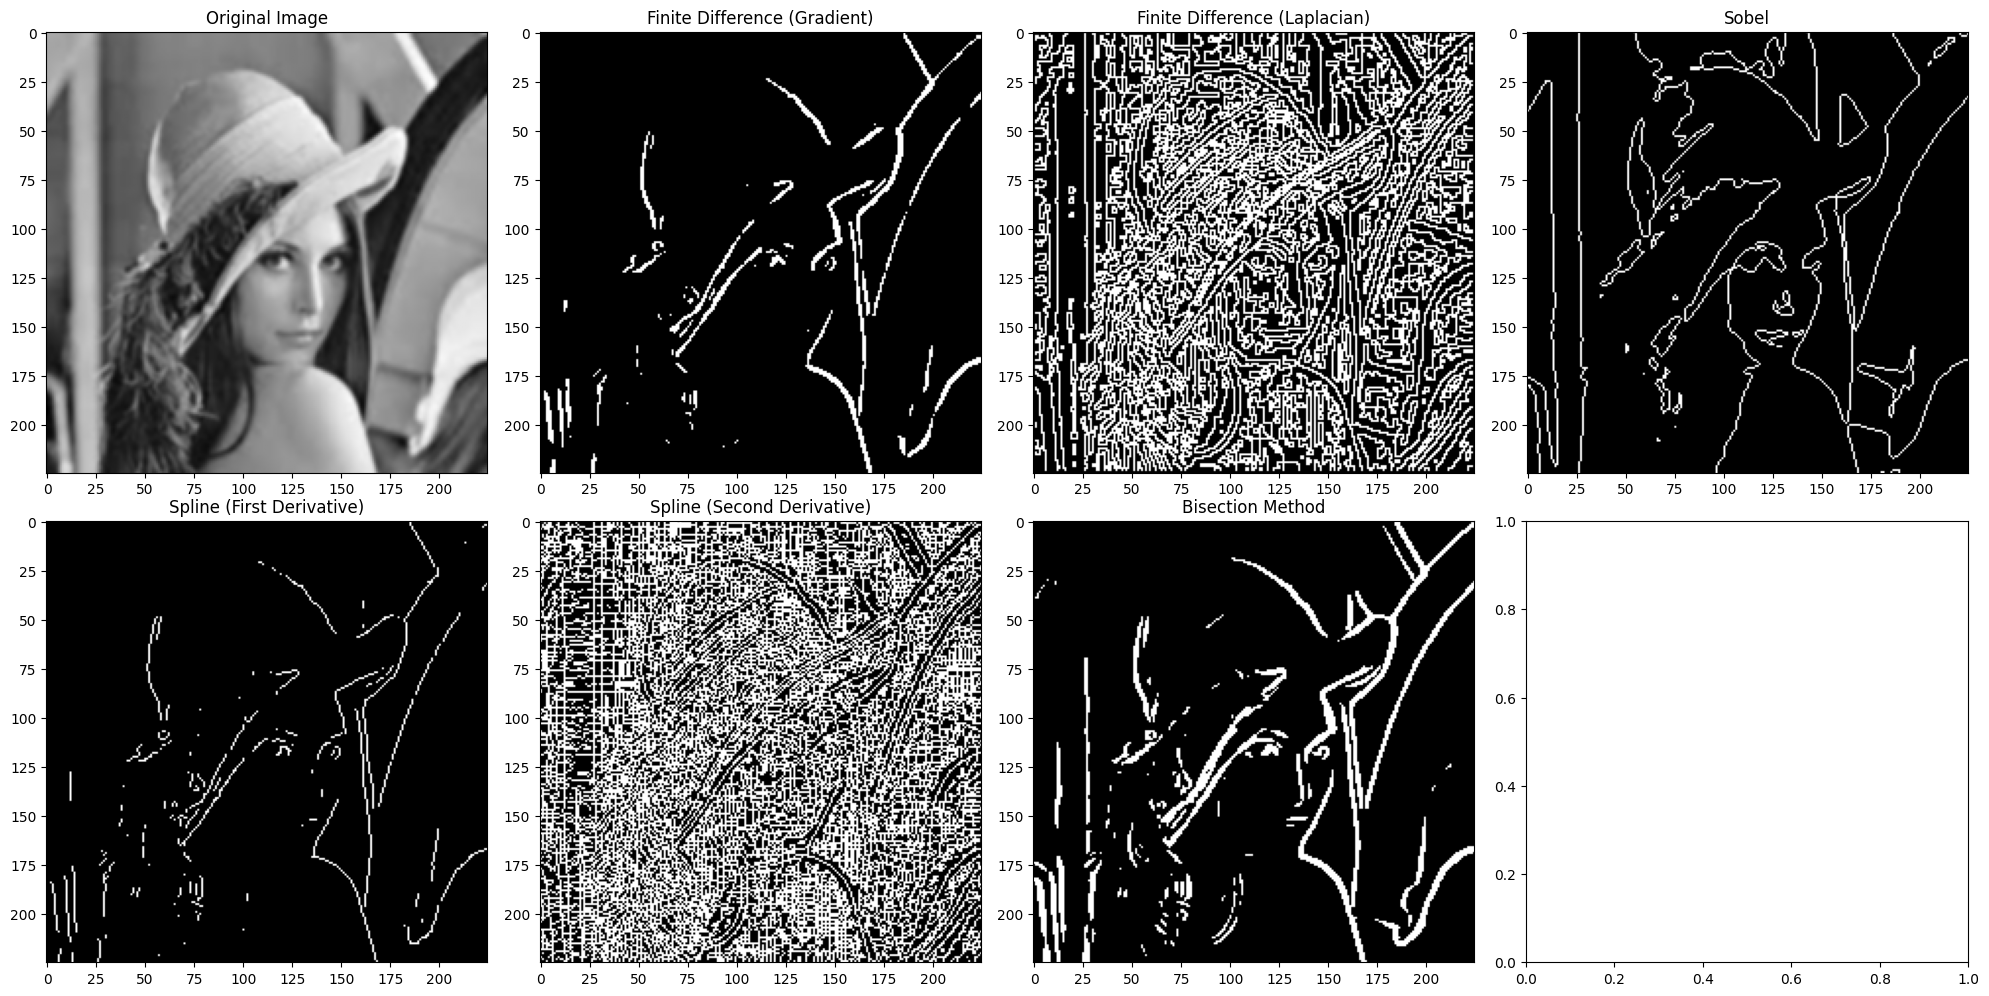

In [31]:

if __name__ == "__main__":
    image_path = "images.jpeg"
    results = compare_edge_detection_methods(image_path)